In [1]:
%%html
<style>
    div.output_stderr { display: none; }
</style>

In [18]:
import time
from IPython.utils import io
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from datetime import datetime
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
start_time = time.time()
# Create SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "5g") \
    .appName('Hadoop to Spark') \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR") # Hidding Spark errors

# Read CSV file from HDFS
path = "hdfs:///CA1_S2/people_increased.csv"  # Use 'hdfs://' prefix to indicate HDFS path
df = spark.read.option("inferSchema", "true").option("header", "true").csv(path)

# Show DataFrame schema
df.printSchema()

# Show first few rows of DataFrame
df.show()

24/03/21 23:07:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- Index: integer (nullable = true)
 |-- User_Id: string (nullable = true)
 |-- First_Name: string (nullable = true)
 |-- Last_Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- DOB: date (nullable = true)
 |-- Job_Title: string (nullable = true)

+-----+---------------+----------+---------+------+--------------------+--------------------+----------+--------------------+
|Index|        User_Id|First_Name|Last_Name|Gender|               Email|               Phone|       DOB|           Job_Title|
+-----+---------------+----------+---------+------+--------------------+--------------------+----------+--------------------+
|    1|4defE49671cF860|    Sydney|  Shannon|  Male|   tvang@example.net|   574-440-1423x9799|2020-07-09|    Technical brewer|
|    2|F89B87bCf8f210b|    Regina|      Lin|  Male| helen14@example.net|001-273-664-2268x...|1909-06-20|Teacher, adult ed...|
|    3|Cad6052BDd5

In [4]:
row_count = df.count()
print(f"The DataFrame has {row_count} rows.")

The DataFrame has 14000000 rows.


In [5]:
# Dropping duplicates based on User_Id
df = df.dropDuplicates(['User_Id'])

In [6]:
row_count = df.count()
print(f"The DataFrame has {row_count} rows.")

The DataFrame has 2000000 rows.


In [7]:
# Convert the Spark DataFrame to a Pandas DataFrame
df= df.toPandas()

# Sorting the df
df = df.sort_values(by='Index', ascending=True).reset_index()

df = df.drop('index', axis=1)

end_time = time.time()

# Display pd df
df

,Index,User_Id,First_Name,Last_Name,Gender,Email,Phone,DOB,Job_Title
0,1,4defE49671cF860,Sydney,Shannon,Male,tvang@example.net,574-440-1423x9799,2020-07-09,Technical brewer
1,2,F89B87bCf8f210b,Regina,Lin,Male,helen14@example.net,001-273-664-2268x90121,1909-06-20,"Teacher, adult education"
2,3,Cad6052BDd5DEaf,Pamela,Blake,Female,brent05@example.org,927-880-5785x85266,1964-08-19,Armed forces operational officer
3,4,e83E46f80f629CD,Dave,Hoffman,Female,munozcraig@example.org,001-147-429-8340x608,2009-02-19,Ship broker
4,5,60AAc4DcaBcE3b6,Ian,Campos,Female,brownevelyn@example.net,166-126-4390,1997-10-02,Media planner
...,...,...,...,...,...,...,...,...,...
1999995,1999996,AbBE4F3Eb5df843,Susan,Ellison,Male,yward@example.net,855.222.4135x62040,1913-01-05,Research scientist (maths)
1999996,1999997,e71af3E8De63CDF,Cole,Sherman,Female,nbarnett@example.org,(130)829-9159x800,1977-04-15,Marketing executive
1999997,1999998,fAF0618097acD1B,Ethan,Leonard,Male,brett57@example.com,514.898.2376x3069,1960-08-14,Photographer
1999998,1999999,f1FC3346F68DFAb,Jordan,Waller,Female,harveykendra@example.com,6920274656,1911-09-05,Chartered accountant


In [8]:
execution_time = end_time - start_time
# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)
print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 2 minutes 51 seconds


In [9]:
# Calculating ppl age.
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = df['DOB'].apply(lambda x: datetime.now().year - x.year)

In [10]:
# Encoding "Sex" as binary values
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])  # Male will be 1, Female will be 0

In [11]:
# Selecting only needed columns

# Dropping columns except 'Sex', 'Date of birth', and 'Job Title'
df = df[['Gender', 'Job_Title','Age']]

# Renaming the column 'Job Title' to 'Job_Title'
df = df.rename(columns={'Job Title': 'Job_Title'})

df = df.reset_index(drop=True).rename_axis(None, axis=1)

df.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27
...,...,...,...
1999995,1,Research scientist (maths),111
1999996,0,Marketing executive,47
1999997,1,Photographer,64
1999998,0,Chartered accountant,113


In [12]:
# Creating df1 to optimise NN
df1 = df.copy()

In [13]:
X = df.iloc[:,1:] # selecting all columns except Gender| Dependent variables
y = df.iloc[:,0] # selecting Gender as our target variable | Independent variable

In [14]:
# Encoding "Job_Title"
encoder = LabelEncoder()
X['Job_Title'] = encoder.fit_transform(X['Job_Title'])  # Each job will have a number assigned 0, 1, 2....

In [15]:
X.head()

,Job_Title,Age
0,592,4
1,584,115
2,45,60
3,544,15
4,369,27


In [19]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: Gender, dtype: int64

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
model = Sequential()
model.add(Dense(10,input_dim=2,activation='relu')) # First layer
model.add(Dense(10,activation='relu')) # Second layer
model.add(Dense(1,activation='sigmoid'))

/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

In [22]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=150, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/150


2024-03-21 23:18:35.063189: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-03-21 23:18:35.078694: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-03-21 23:18:35.196188: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-03-21 23:18:35.197769: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-03-21 23:18:36.029295: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


3907/3907 - 4s - 1ms/step - accuracy: 0.5001 - loss: 0.6933
Epoch 2/150
3907/3907 - 3s - 806us/step - accuracy: 0.4996 - loss: 0.6932
Epoch 3/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5002 - loss: 0.6932
Epoch 4/150
3907/3907 - 6s - 1ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 5/150
3907/3907 - 3s - 889us/step - accuracy: 0.4998 - loss: 0.6932
Epoch 6/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5001 - loss: 0.6932
Epoch 7/150
3907/3907 - 5s - 1ms/step - accuracy: 0.4998 - loss: 0.6932
Epoch 8/150
3907/3907 - 4s - 1ms/step - accuracy: 0.5004 - loss: 0.6931
Epoch 9/150
3907/3907 - 6s - 2ms/step - accuracy: 0.4996 - loss: 0.6931
Epoch 10/150
3907/3907 - 6s - 2ms/step - accuracy: 0.5005 - loss: 0.6931
Epoch 11/150
3907/3907 - 8s - 2ms/step - accuracy: 0.5001 - loss: 0.6931
Epoch 12/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5000 - loss: 0.6931
Epoch 13/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5004 - loss: 0.6931
Epoch 14/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5006 - loss: 0.

Epoch 113/150
3907/3907 - 5s - 1ms/step - accuracy: 0.4997 - loss: 0.6931
Epoch 114/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5004 - loss: 0.6931
Epoch 115/150
3907/3907 - 4s - 1ms/step - accuracy: 0.5004 - loss: 0.6932
Epoch 116/150
3907/3907 - 4s - 1ms/step - accuracy: 0.4996 - loss: 0.6931
Epoch 117/150
3907/3907 - 4s - 1ms/step - accuracy: 0.5002 - loss: 0.6931
Epoch 118/150
3907/3907 - 4s - 1ms/step - accuracy: 0.4998 - loss: 0.6931
Epoch 119/150
3907/3907 - 5s - 1ms/step - accuracy: 0.4997 - loss: 0.6931
Epoch 120/150
3907/3907 - 5s - 1ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 121/150
3907/3907 - 4s - 1ms/step - accuracy: 0.5000 - loss: 0.6931
Epoch 122/150
3907/3907 - 5s - 1ms/step - accuracy: 0.4997 - loss: 0.6931
Epoch 123/150
3907/3907 - 5s - 1ms/step - accuracy: 0.5002 - loss: 0.6931
Epoch 124/150
3907/3907 - 8s - 2ms/step - accuracy: 0.5001 - loss: 0.6931
Epoch 125/150
3907/3907 - 8s - 2ms/step - accuracy: 0.5004 - loss: 0.6931
Epoch 126/150
3907/3907 - 4s - 1ms/ste

In [23]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 12 minutes 1 seconds


In [24]:
# Convert history.history dict to a pandas DataFrame
history_df = pd.DataFrame(history.history)

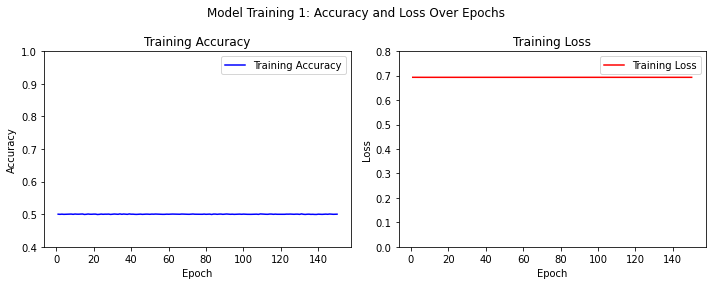

In [25]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(.4, 1)  # Set the y-axis limits for accuracy
plt.legend()

plt.suptitle("Model Training 1: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.8) # Set the y-axis limits for loss
plt.legend()

plt.tight_layout()
plt.show()

## The NN is clearly not performing well. Let's treat each job as a feature and transpose them into columns, filling each column with the Age.

In [26]:
df1.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27


In [27]:
# Add a unique identifier for each row within each group of 'Sex' and 'Job_Title'
df1['unique_id'] = df1.groupby(['Gender', 'Job_Title']).cumcount()

# Pivot the table, using 'Sex' and 'unique_id' as the index
df1 = df1.pivot_table(index=['Gender', 'unique_id'], columns='Job_Title', values='Age').reset_index()
df1  = df1.rename_axis(None, axis=1) # Index with no name as it should be

# Drop the 'unique_id' column as it's no longer needed, keeping 'Sex'
df1.drop('unique_id', axis=1, inplace=True)

# Display the result
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3385,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3386,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3387,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df1 = df1.dropna()

In [29]:
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,1,23.0,38.0,86.0,36.0,6.0,61.0,53.0,70.0,80.0,...,82.0,87.0,72.0,100.0,35.0,18.0,22.0,86.0,71.0,92.0
3134,1,23.0,78.0,43.0,65.0,109.0,33.0,109.0,94.0,76.0,...,93.0,22.0,107.0,25.0,87.0,108.0,16.0,19.0,47.0,81.0
3135,1,18.0,61.0,93.0,33.0,23.0,6.0,104.0,91.0,36.0,...,31.0,81.0,24.0,81.0,112.0,78.0,26.0,43.0,97.0,12.0
3136,1,60.0,59.0,75.0,55.0,3.0,87.0,50.0,71.0,98.0,...,101.0,118.0,103.0,88.0,88.0,18.0,67.0,29.0,22.0,86.0


In [30]:
X = df1.iloc[:,1:] # selecting all columns except Gender | Dependent variable
y = df1.iloc[:,0] # selecting column Gender as our target variable | Independent variable

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [32]:
model = Sequential()
model.add(Dense(10,input_dim=639,activation='relu')) # First layer
model.add(Dense(10,activation='relu')) # Second layer
model.add(Dense(1,activation='sigmoid'))

/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

In [34]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=150, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/150
6/6 - 1s - 218ms/step - accuracy: 0.5002 - loss: 0.7457
Epoch 2/150
6/6 - 0s - 23ms/step - accuracy: 0.5397 - loss: 0.7063
Epoch 3/150
6/6 - 0s - 20ms/step - accuracy: 0.5752 - loss: 0.6814
Epoch 4/150
6/6 - 0s - 25ms/step - accuracy: 0.6065 - loss: 0.6604
Epoch 5/150
6/6 - 0s - 13ms/step - accuracy: 0.6302 - loss: 0.6458
Epoch 6/150
6/6 - 0s - 19ms/step - accuracy: 0.6526 - loss: 0.6327
Epoch 7/150
6/6 - 0s - 12ms/step - accuracy: 0.6756 - loss: 0.6186
Epoch 8/150
6/6 - 0s - 19ms/step - accuracy: 0.6949 - loss: 0.6073
Epoch 9/150
6/6 - 0s - 9ms/step - accuracy: 0.7145 - loss: 0.5944
Epoch 10/150
6/6 - 0s - 14ms/step - accuracy: 0.7258 - loss: 0.5821
Epoch 11/150
6/6 - 0s - 11ms/step - accuracy: 0.7355 - loss: 0.5713
Epoch 12/150
6/6 - 0s - 17ms/step - accuracy: 0.7434 - loss: 0.5573
Epoch 13/150
6/6 - 0s - 19ms/step - accuracy: 0.7513 - loss: 0.5458
Epoch 14/150
6/6 - 0s - 24ms/step - accuracy: 0.7606 - loss: 0.5334
Epoch 15/150
6/6 - 0s - 23ms/step - accuracy: 0.7681 - lo

Epoch 122/150
6/6 - 0s - 7ms/step - accuracy: 0.9966 - loss: 0.0149
Epoch 123/150
6/6 - 0s - 13ms/step - accuracy: 0.9966 - loss: 0.0150
Epoch 124/150
6/6 - 0s - 7ms/step - accuracy: 0.9966 - loss: 0.0143
Epoch 125/150
6/6 - 0s - 12ms/step - accuracy: 0.9969 - loss: 0.0139
Epoch 126/150
6/6 - 0s - 11ms/step - accuracy: 0.9969 - loss: 0.0139
Epoch 127/150
6/6 - 0s - 13ms/step - accuracy: 0.9969 - loss: 0.0141
Epoch 128/150
6/6 - 0s - 11ms/step - accuracy: 0.9969 - loss: 0.0131
Epoch 129/150
6/6 - 0s - 18ms/step - accuracy: 0.9969 - loss: 0.0127
Epoch 130/150
6/6 - 0s - 13ms/step - accuracy: 0.9969 - loss: 0.0131
Epoch 131/150
6/6 - 0s - 10ms/step - accuracy: 0.9969 - loss: 0.0127
Epoch 132/150
6/6 - 0s - 12ms/step - accuracy: 0.9972 - loss: 0.0122
Epoch 133/150
6/6 - 0s - 21ms/step - accuracy: 0.9972 - loss: 0.0121
Epoch 134/150
6/6 - 0s - 14ms/step - accuracy: 0.9972 - loss: 0.0121
Epoch 135/150
6/6 - 0s - 19ms/step - accuracy: 0.9972 - loss: 0.0114
Epoch 136/150
6/6 - 0s - 13ms/step -

In [35]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 0 minutes 15 seconds


In [36]:
# Converting history into a DataFrame
history_df1 = pd.DataFrame(history.history)

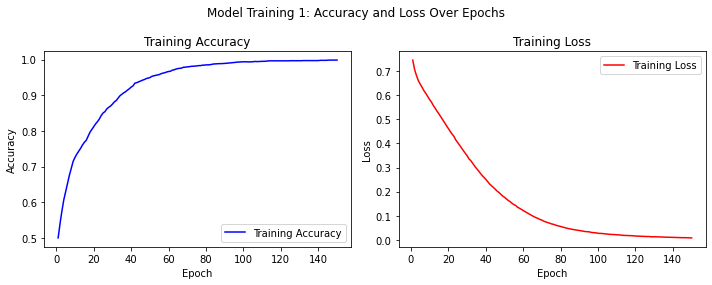

In [40]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df1) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle("Model Training 1: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()